In [1]:
import random

import pandas as pd
import openTSNE as ot
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from collections import OrderedDict
from sklearn.metrics import precision_recall_fscore_support as score

import h5py
from tsne_functions import plot_tsne

import numpy as np
 


In [2]:
with h5py.File('scaledata.h5','r') as file:

    #As h5 file was saved in R it is imported as transposed
    data_int=pd.DataFrame(file.get('integrated/matrix')[:file.get('integrated/matrix').shape[0],:])
    data_int.columns=[name.decode() for name in file.get('integrated/rownames')]
    data_int.index=[name.decode() for name in file.get('integrated/colnames')[:file.get('integrated/colnames').shape[0]]]

In [3]:
col_data=pd.read_table('passedQC_cellData.tsv',index_col=0)

In [8]:
def make_tsne(data: pd.DataFrame, perplexities_range: list = [50, 500],
              exaggerations: list = [12, 1.2],
              momentums: list = [0.6, 0.94], random_state=0,initial_split:int=1) -> ot.TSNEEmbedding:
    """
    Make tsne embedding. Uses openTSNE Multiscale followed by optimizations. Each optimization has exaggeration and
    momentum parameter - these are used sequentially from exaggerations and momenutms lists, which must be of same
    lengths. There are as many optimizations as are lengths of optimization parameter lists.
    :param data: Samples in rows,features in columns. Must be numeric
    :param perplexities_range: Used for openTSNE.affinity.Multiscale
    :param exaggerations: List of exaggeration parameters for sequential optimizations
    :param momentums: List of momentum parameters for sequential optimizations
    :param random_state: random state
    :param initial_split: tSNE embedding is first performed on N/initial_split samples where N is N of samples 
        and then extended to the remaining samples. If 1 tSNE is performed on whole dataset at once.
    :return: Embedding: functions as list of lists, where 1st object in nested list is x position and 2nd is y.
        There is one nested list for each sample
    """
    if len(exaggerations) != len(momentums):
        raise ValueError('Exagerrations and momenutms list lengths must match')
    if initial_split<1:
        raise ValueError('Initial split must be at least 1, meaning that data is not split.')
    
    if initial_split>1:
        np.random.seed(random_state)
        n=data.shape[0]
        indices = np.random.permutation(list(range(n)))
        reverse = np.argsort(indices)
        sub1, sub2 = data.iloc[indices[:int(n/initial_split)],:], data.iloc[indices[int(n/initial_split):],:]
    else:
        sub1=data
    
    init1 = ot.initialization.pca(sub1,random_state=random_state)
    affinities1 = ot.affinity.Multiscale(sub1, perplexities=perplexities_range,
                                                        metric="cosine", n_jobs=30, random_state=random_state)
    embedding1 = ot.TSNEEmbedding(init1, affinities1, negative_gradient_method="fft", n_jobs=30)
    for exaggeration, momentum in zip(exaggerations, momentums):
        embedding1 = embedding1.optimize(n_iter=250, exaggeration=exaggeration, momentum=momentum)
    
    if initial_split>1:
        embedding2 = embedding1.prepare_partial(sub2, k=3,perplexities=np.array(perplexities_range)/100)
        embedding_init = np.vstack((embedding1, embedding2))[reverse]
        embedding_init=embedding_init/ (np.std(embedding_init[:, 0]) * 10000)
        
        affinities = ot.affinity.Multiscale(data, perplexities=perplexities_range,
                                                           metric="cosine", n_jobs=30, random_state=random_state)
        embedding = ot.TSNEEmbedding(embedding_init,affinities,learning_rate=1000,negative_gradient_method="fft",n_jobs=30,
                          random_state=random_state)
        for exaggeration, momentum in zip(exaggerations, momentums):
            embedding = embedding.optimize(n_iter=250, exaggeration=exaggeration, momentum=momentum)
        
        
    else:
        embedding=embedding1
    
    return embedding

In [4]:
perplexities_range = [50, 500]
exaggerations= [15, 1.5]
momentums = [0.6, 0.98]
random_state=0
data=data_int
col_data_plot=col_data.loc[data.index,:]
initial_split=30

In [5]:
np.random.seed(random_state)
n=data.shape[0]
indices = np.random.permutation(list(range(n)))
reverse = np.argsort(indices)
sub1, sub2 = data.iloc[indices[:int(n/initial_split)],:], data.iloc[indices[int(n/initial_split):],:]

In [7]:
affinities = ot.affinity.Multiscale(data, perplexities=perplexities_range,
                                                           metric="cosine", n_jobs=30, random_state=random_state)

/home/khrovatin/miniconda3/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
/home/khrovatin/miniconda3/lib/python3.7/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../miniconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [43]:
init1 = ot.initialization.pca(sub1,random_state=random_state)

In [ ]:
affinities1 = ot.affinity.Multiscale(sub1, perplexities=perplexities_range,
                                                           metric="cosine", n_jobs=30, random_state=random_state)

/home/khrovatin/miniconda3/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "


In [ ]:
embedding1 = ot.TSNEEmbedding(init1, affinities1, negative_gradient_method="fft", n_jobs=30)
for exaggeration, momentum in zip(exaggerations, momentums):
    embedding1 = embedding1.optimize(n_iter=250, exaggeration=exaggeration, momentum=momentum)

In [32]:
embedding2 = embedding1.prepare_partial(sub2, k=3,perplexities=np.array(perplexities_range)/100)
embedding_init = np.vstack((embedding1, embedding2))[reverse]

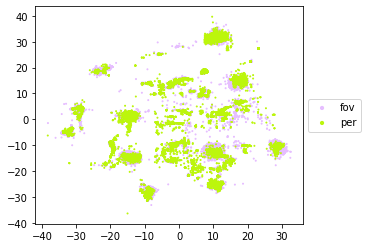

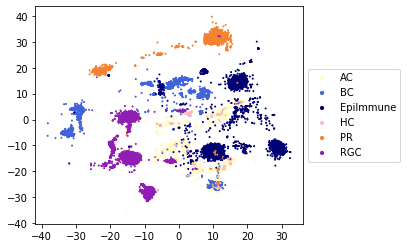

In [33]:
plot_tsne([embedding_init],[dict(zip(col_data_plot.index,col_data_plot['region']))], [data.index], legend=True)
plot_tsne([embedding_init],[dict(zip(col_data_plot.index,col_data_plot['cell_type']))], [data.index], legend=True)

In [34]:
embedding_init=embedding_init/ (np.std(embedding_init[:, 0]) * 10000)

In [35]:
import openTSNE.callbacks

In [36]:
embedding = ot.TSNEEmbedding(embedding_init,affinities,learning_rate=1000,negative_gradient_method="fft",n_jobs=30,
                          random_state=random_state, callbacks=openTSNE.callbacks.ErrorLogger(), max_grad_norm=0.25)


In [37]:
for exaggeration, momentum in zip(exaggerations, momentums):
    embedding = embedding.optimize(n_iter=250, exaggeration=exaggeration, momentum=momentum)

Iteration   50, KL divergence  6.5336, 50 iterations in 37.4484 sec
Iteration  100, KL divergence  5.6415, 50 iterations in 38.5959 sec
Iteration  150, KL divergence  4.8583, 50 iterations in 38.2666 sec
Iteration  200, KL divergence  4.6355, 50 iterations in 41.9632 sec
Iteration  250, KL divergence  4.4894, 50 iterations in 55.3144 sec
Iteration   50, KL divergence  3.5798, 50 iterations in 43.7594 sec
Iteration  100, KL divergence  3.2506, 50 iterations in 94.5709 sec
Iteration  150, KL divergence  3.1095, 50 iterations in 167.6879 sec
Iteration  200, KL divergence  3.0370, 50 iterations in 197.8115 sec
Iteration  250, KL divergence  2.9887, 50 iterations in 205.2864 sec


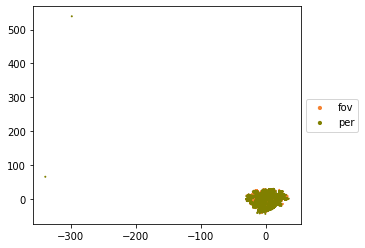

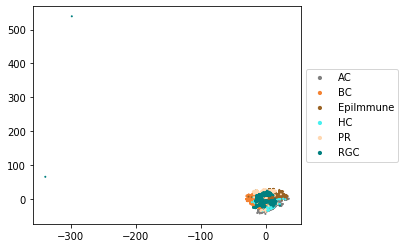

In [38]:
plot_tsne([embedding],[dict(zip(col_data_plot.index,col_data_plot['region']))], [data.index], legend=True)
plot_tsne([embedding],[dict(zip(col_data_plot.index,col_data_plot['cell_type']))], [data.index], legend=True)

/home/khrovatin/miniconda3/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
/home/khrovatin/miniconda3/lib/python3.7/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../miniconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


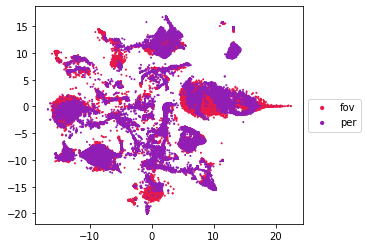

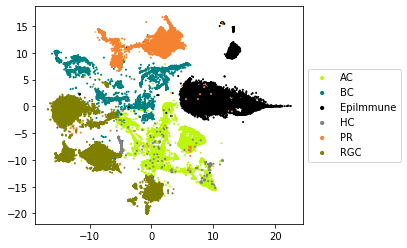

In [9]:
tsne=make_tsne(data=data_int, perplexities_range = [50, 500],
              exaggerations = [15, 1.2],
              momentums = [0.6, 0.96], random_state=0,initial_split=1)
plot_tsne([tsne],[dict(zip(col_data.index,col_data['region']))], [data_int.index], legend=True)
plot_tsne([tsne],[dict(zip(col_data.index,col_data['cell_type']))], [data_int.index], legend=True)

/home/khrovatin/miniconda3/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "


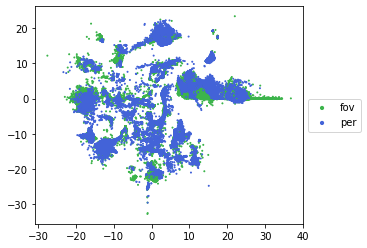

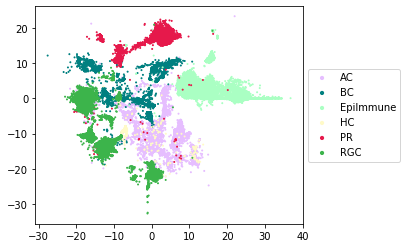

In [11]:
tsne=make_tsne(data=data_int, perplexities_range = [50, 500],
              exaggerations = [15, 1.5],
              momentums = [0.6, 0.98], random_state=0,initial_split=1)
plot_tsne([tsne],[dict(zip(col_data.index,col_data['region']))], [data_int.index], legend=True)
plot_tsne([tsne],[dict(zip(col_data.index,col_data['cell_type']))], [data_int.index], legend=True)

/home/khrovatin/miniconda3/lib/python3.7/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "


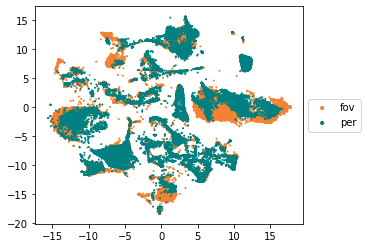

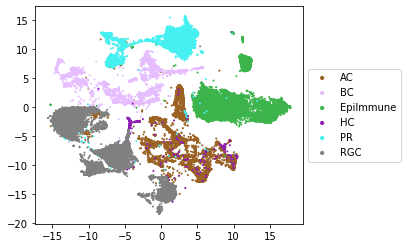

In [12]:
tsne=make_tsne(data=data_int, perplexities_range = [50, 500],
              exaggerations = [12, 1.2],
              momentums = [0.6, 0.94], random_state=0,initial_split=1)
plot_tsne([tsne],[dict(zip(col_data.index,col_data['region']))], [data_int.index], legend=True)
plot_tsne([tsne],[dict(zip(col_data.index,col_data['cell_type']))], [data_int.index], legend=True)